In [349]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Intelligent Data Analysis Project: Income

A polling institute wants to be able to estimate an individual’s income from his/her personal data (see einkommen.train). To this aim, 30.000 individuals were interviewed concerning the features summarized below. For some of the individuals, not all features are available. Crucially, the income of only 5.000 of the interviewee’s is known.

Your task is to predict the income group of the remaining 25.000 interviewees and to prepare the data such that they can be used for further regression and correlation analyses.

Load the data into Python and preprocess it. Choose adequate data transformations, normalizations etc. and decide on how to deal with missing values (marked with “?”). Consider which kinds of features the preprocessed data shall contain. Once you have preprocessed the data, train a model to predict a person’s income group and apply it to the 25.000 individuals whose income group is unknown. Identify a suitable learning method and implement it in Python. Train and evaluate the model. Provide a short documentation and motivation of each of your steps.

In [322]:
# Import data set and add column names
income = pd.read_csv('data/income/einkommen.train', sep=",", na_values = " ?", header=None)
columns = ["Age", "Employment type", "Interview-dependent", "Education level", "Schooling/training period", "Marital Status", "Employment area", "Partnership", "Ethnicity", "Gender", "Gains", "Losses", "Working time(Weekly)", "Country", "Income"]
income.columns = columns

In [323]:
# Split data set into sets where Income is known or unknwn
income_labeled = income[income['Income'].notnull()]
income_unlabeled = income[income['Income'].isnull()]

In [324]:
income_labeled.nunique()

Age                            69
Employment type                 7
Interview-dependent          4603
Education level                16
Schooling/training period      16
Marital Status                  7
Employment area                14
Partnership                     6
Ethnicity                       5
Gender                          2
Gains                          83
Losses                         55
Working time(Weekly)           74
Country                        39
Income                          2
dtype: int64

In [325]:
income_labeled.isna().sum()

Age                            0
Employment type              331
Interview-dependent            0
Education level                0
Schooling/training period      0
Marital Status                 0
Employment area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Working time(Weekly)           0
Country                       97
Income                         0
dtype: int64

In [326]:
# income_labeled[income_labeled['Employment area'].isnull()].sort_values(by="Working time(Weekly)")
# income_labeled['Country'].unique()

## Problem Setting

## Analysis

In [327]:
# Look at input values
income_labeled.head()

,Age,Employment type,Interview-dependent,Education level,Schooling/training period,Marital Status,Employment area,Partnership,Ethnicity,Gender,Gains,Losses,Working time(Weekly),Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [328]:
income_labeled.describe()

,Age,Interview-dependent,Schooling/training period,Gains,Losses,Working time(Weekly)
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.600200,1.907684e+05,10.079600,1033.640200,93.696800,40.519000
std,13.594695,1.063596e+05,2.534906,7051.802077,410.801418,12.109193
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176958e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.794750e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.416575e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.033222e+06,16.000000,99999.000000,2547.000000,99.000000


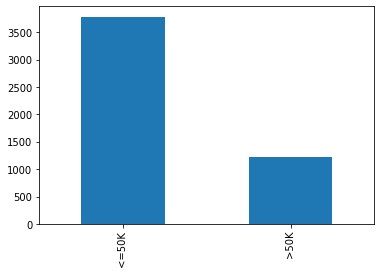

In [329]:
# Check balance between label that has to be predicted
target_distribution = income_labeled['Income'].value_counts().plot(kind='bar')

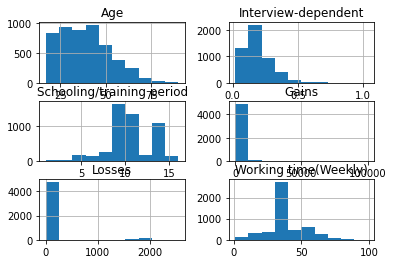

In [330]:
# Check how numeric values are distributed
numeric_distribution = income_labeled.hist()

[Text(1, 0, 'Age'),
 Text(2, 0, 'Schooling/training period'),
 Text(3, 0, 'Working time(Weekly)')]

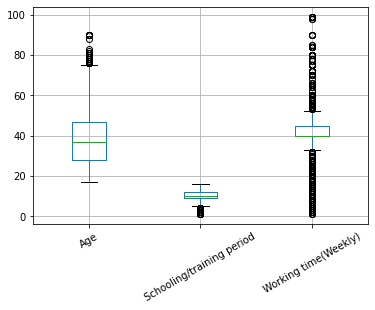

In [331]:
ax = income_labeled.drop(['Interview-dependent', 'Gains', 'Losses',], axis=1).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

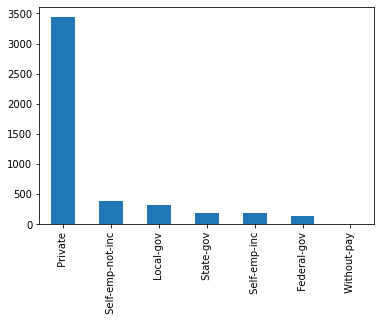

In [332]:
employment_type_distribution = income_labeled['Employment type'].value_counts().plot(kind='bar')

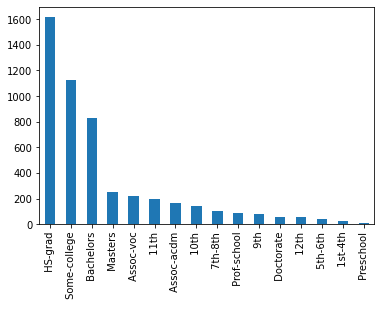

In [333]:
education_distribution = income_labeled['Education level'].value_counts().plot(kind='bar')

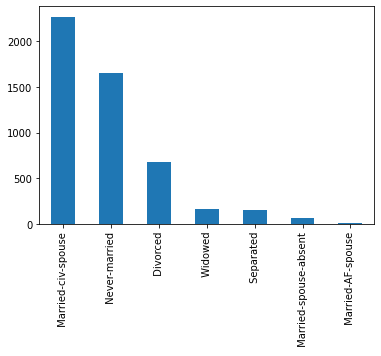

In [334]:
maritial_status_distribution = income_labeled['Marital Status'].value_counts().plot(kind='bar')

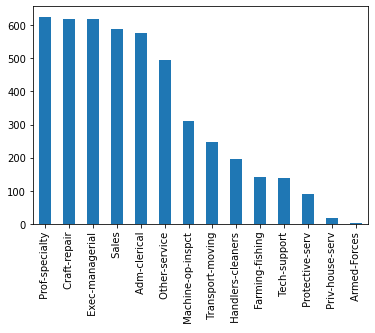

In [335]:
employment_area_distribution = income_labeled['Employment area'].value_counts().plot(kind='bar')

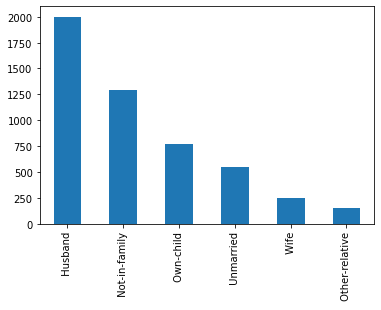

In [336]:
partnership_distributon = income_labeled['Partnership'].value_counts().plot(kind='bar')

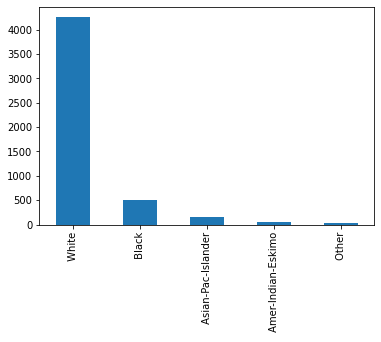

In [337]:
ethnicity_distribution = income_labeled['Ethnicity'].value_counts().plot(kind='bar')

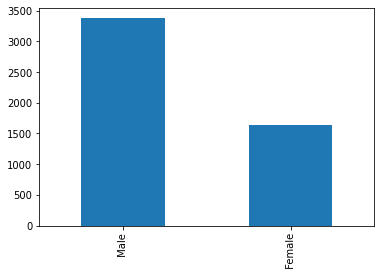

In [338]:
gender_distribution = income_labeled['Gender'].value_counts().plot(kind='bar')

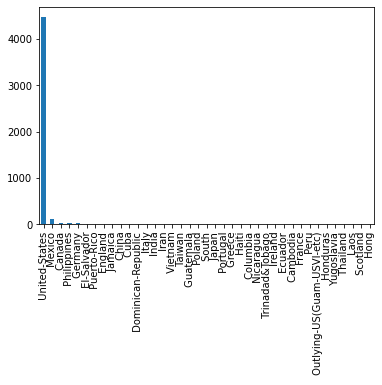

In [339]:
country_distribution = income_labeled['Country'].value_counts().plot(kind='bar')

## Data Preparation

In [340]:
## Handling Missing Values
print(income_labeled.isna().sum())

# income_labeled = income_labeled.dropna()

# print(income_labeled.nunique())

income_labeled[income_labeled['Employment area'].isnull()]


# income_labeled['Employment area'].unique()

Age                            0
Employment type              331
Interview-dependent            0
Education level                0
Schooling/training period      0
Marital Status                 0
Employment area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Working time(Weekly)           0
Country                       97
Income                         0
dtype: int64


,Age,Employment type,Interview-dependent,Education level,Schooling/training period,Marital Status,Employment area,Partnership,Ethnicity,Gender,Gains,Losses,Working time(Weekly),Country,Income
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K
69,25,NaN,200681,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,NaN,212759,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
106,17,NaN,304873,10th,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,17,NaN,139183,10th,6,Never-married,NaN,Own-child,White,Female,0,0,15,United-States,<=50K
4958,20,NaN,293136,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,35,United-States,<=50K
4970,51,NaN,203953,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,>50K
4980,45,NaN,144354,9th,5,Separated,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K


In [341]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for Education Level
education_level = ['Preschool','1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
oe_edu = OrdinalEncoder(categories=[education_level])

income_labeled['Education level'] = income_labeled['Education level'].str.strip()
income_labeled['Education level'] = oe_edu.fit_transform(income_labeled[['Education level']])

In [342]:
# One-Hot Encoding
# Employment Type, Marital status, Employment Area, Partnership, Ethnicity, Gender, Country
one_hot_columns = ['Employment type', 'Marital Status', 'Employment area', 'Partnership', 'Ethnicity', 'Gender', 'Country']
income_labeled = pd.get_dummies(income_labeled, columns=one_hot_columns)


In [343]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encode categorical variables
income_labeled['Income'].replace([' <=50K', ' >50K'], [0, 1], inplace=True)

In [344]:
# Standardization / Z-Score Normalization


In [345]:
from sklearn.model_selection import train_test_split

# Train / Test-Split
income_X_train, income_X_test, income_y_train, income_y_test = train_test_split(income_labeled.drop('Income', axis=1), income_labeled['Income'], test_size=0.25, random_state=42)

## Methods (& Experiments)

### Linear Classification

In [346]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(random_state=42)
clf.fit(income_X_train, income_y_train)

income_y_pred = clf.predict(income_X_test)

accuracy_score(income_y_test, income_y_pred)

0.7304

### Decision Trees

0.7824

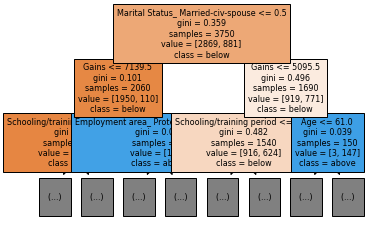

In [347]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(income_X_train, income_y_train)
tree.plot_tree(clf, max_depth=2, fontsize=8, feature_names=income_X_train.columns, filled=True, class_names=["below", "above"])

income_y_pred = clf.predict(income_X_test)

accuracy_score(income_y_test, income_y_pred)

## Conclusion